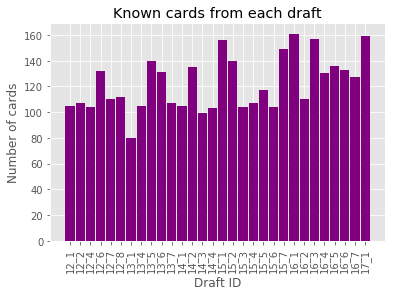

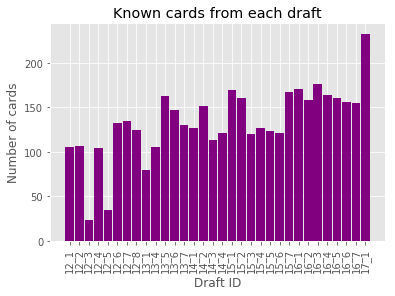

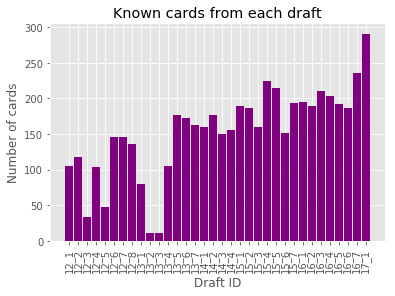

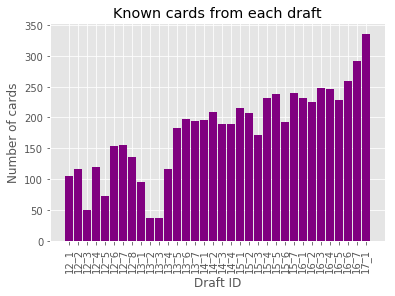

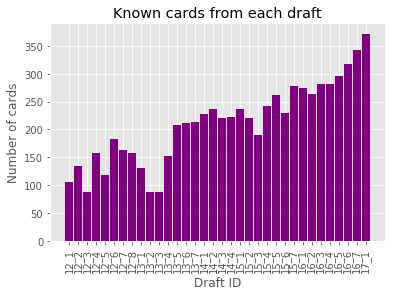

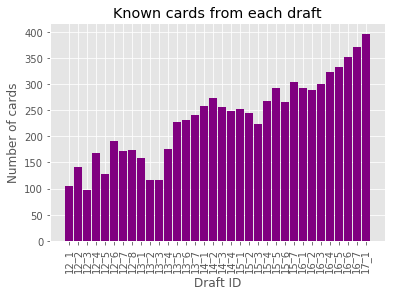

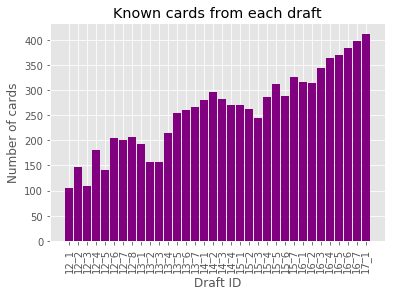

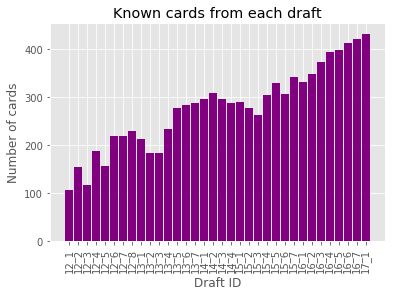

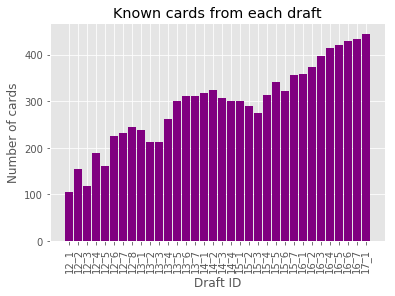

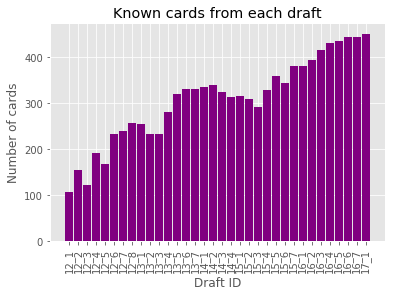

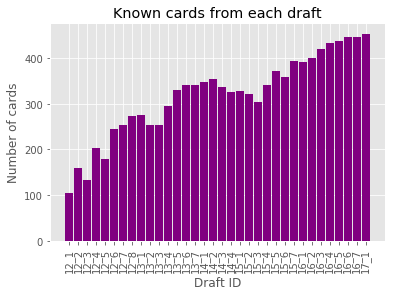

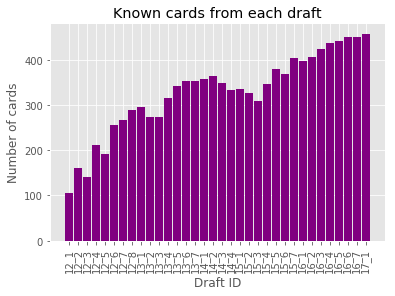

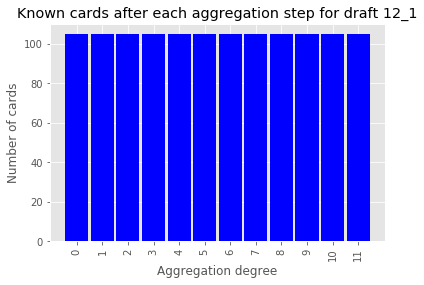

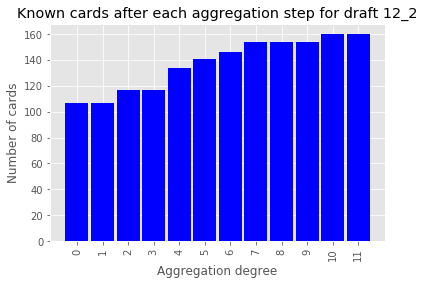

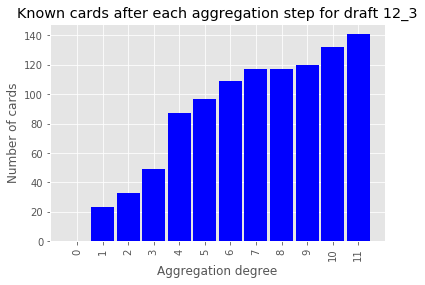

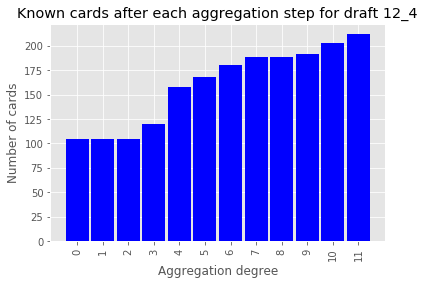

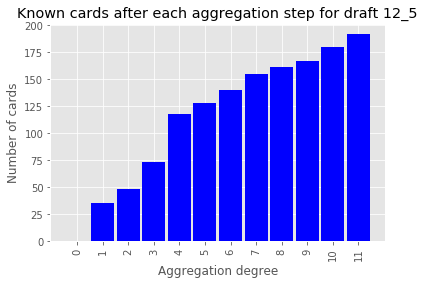

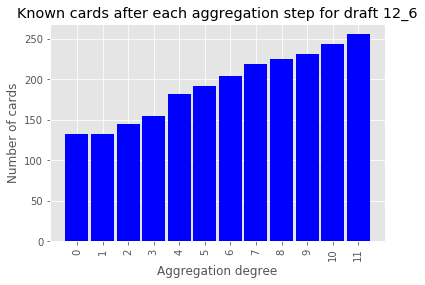

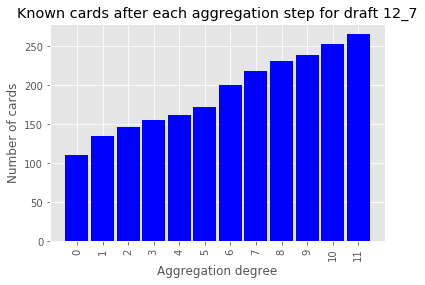

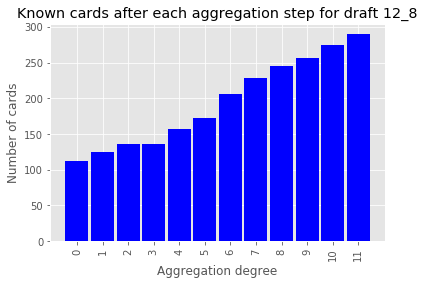

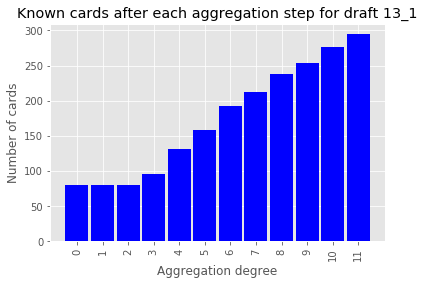

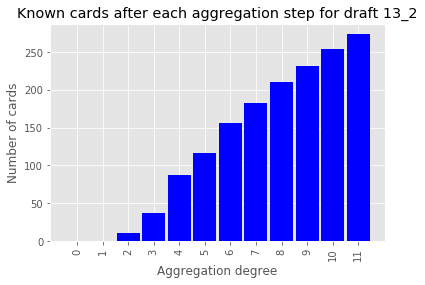

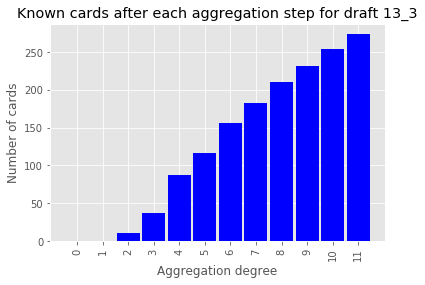

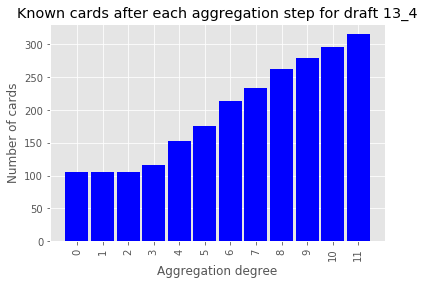

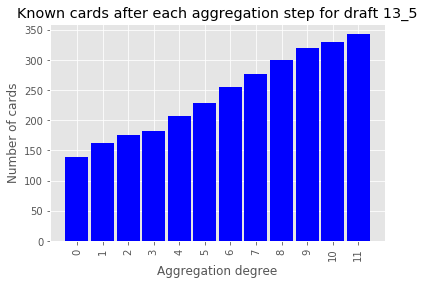

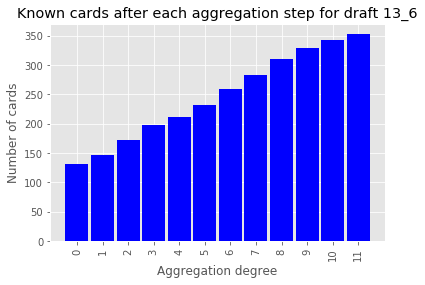

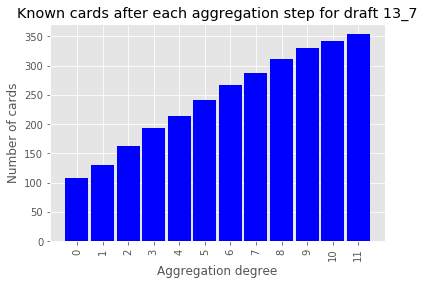

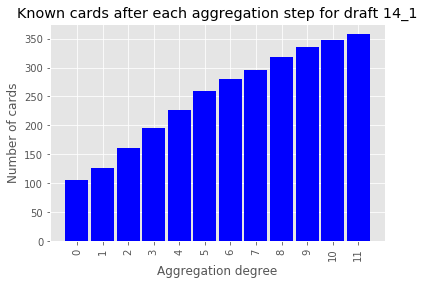

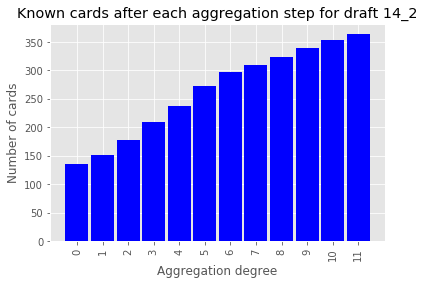

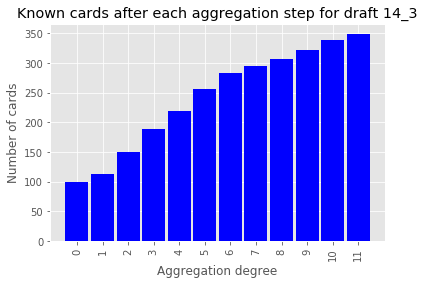

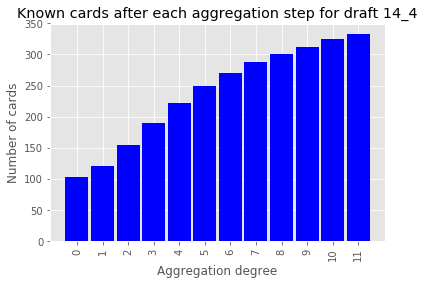

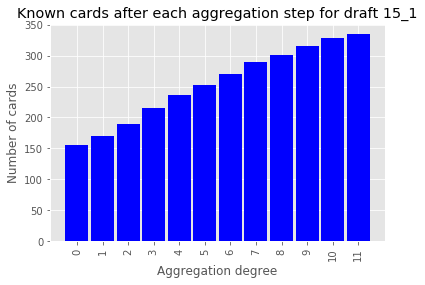

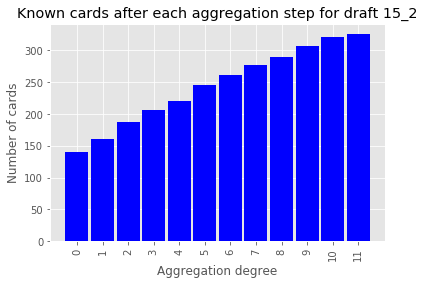

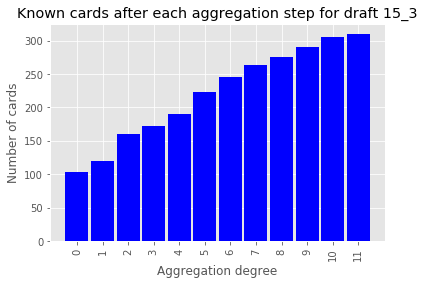

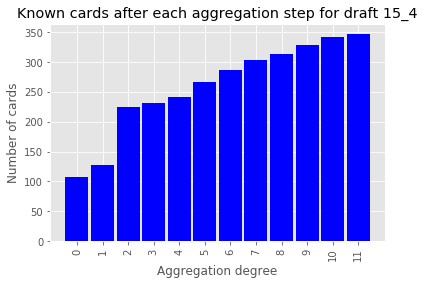

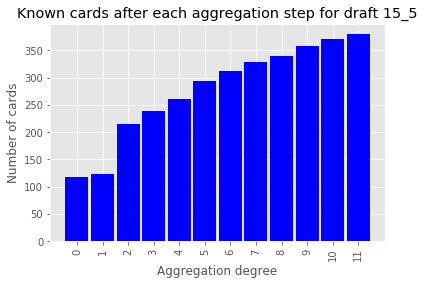

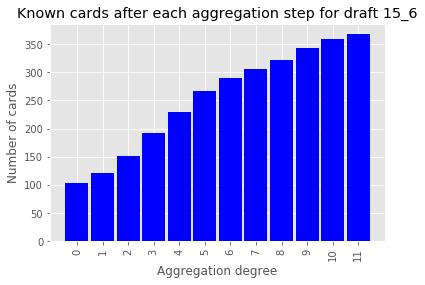

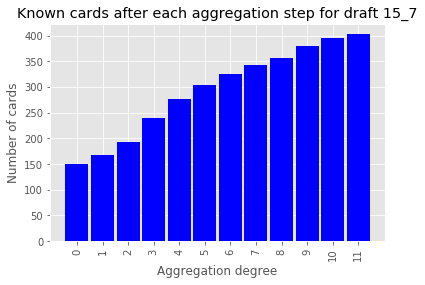

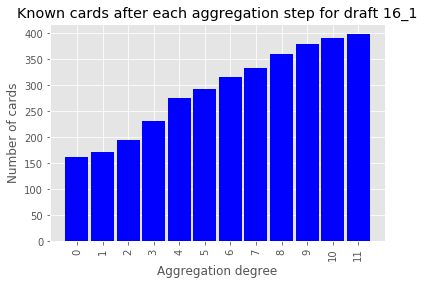

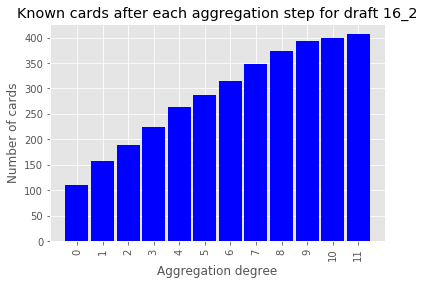

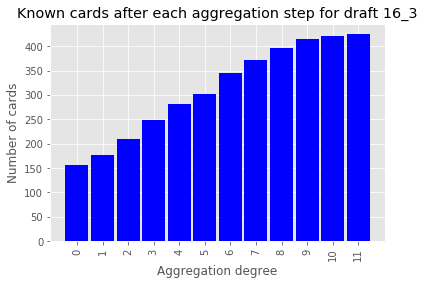

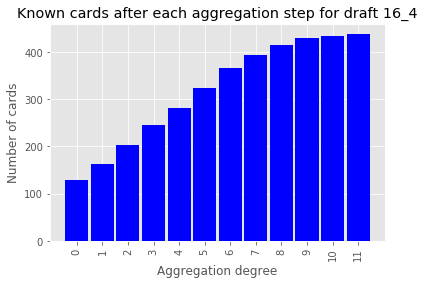

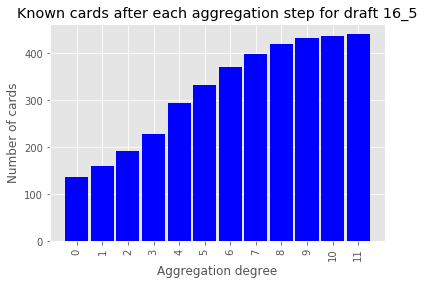

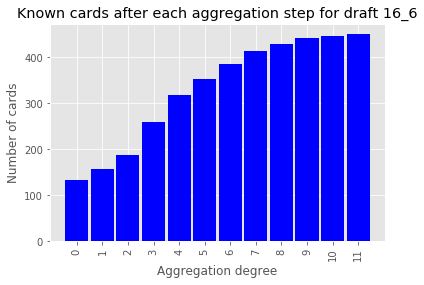

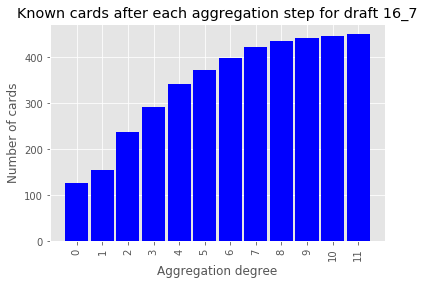

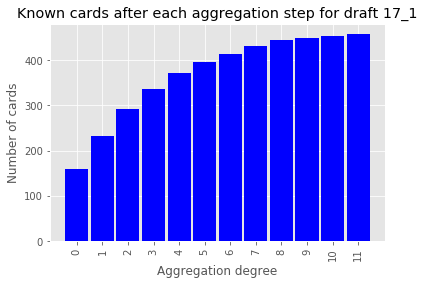

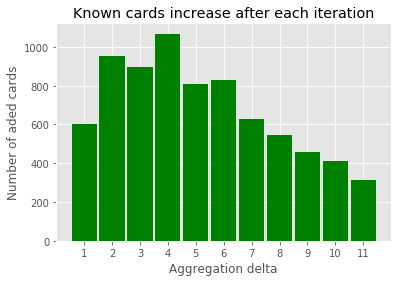

In [200]:
# Module for reconstruction of cube list from ancient times

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

decklists_path = 'data/decks/'
cubes_path = 'data/cubes/'

numbered_map = {
    '17_2':'17_2',
    '17_3':'17_2',
    '17_4':'17_2',
    '17_5':'17_5',
    '17_6':'17_6',
    '17_7':'17_6',
    '17_8':'17_6'
}

class Reconstructor():
    def __init__(self):
        self.deckfiles = []
        self.cubefiles = []
        self.labels_full = []
        self.labels_notfull = []
        self.labels_all = []
        self.label_cards_lib = {}
        self.loadAllDeckFilenames()
        self.loadAllCubeFilenames()
        self.getLabelsFull()
        self.getLabelsNotFull()
        self.loadAllDraftLabels()
        self.getCardsForAllLabels()
        self.aggregated_lengths = {}
        self.prepareAggregatedLengthsLib()
        
        
    def loadAllDeckFilenames(self):
        if len(self.deckfiles) == 0:
            tmp = os.listdir(decklists_path)
            deckfiles = []
            for i in tmp:
                deckfiles.append(i.replace('~', ''))
            self.deckfiles = sorted(list(set(deckfiles)))
            
    def loadAllCubeFilenames(self):
        if len(self.cubefiles) == 0:
            tmp = os.listdir(cubes_path)
            cubes = []
            for i in tmp:
                cubes.append(i.replace('~', ''))
            self.cubefiles = sorted(list(set(cubes)))
            
    def loadAllDraftLabels(self):
        if len(self.labels_all) == 0:
            loaded_labels = []
            my_file = open('data/draft_info.txt', 'r')
            my_string = my_file.read()
            my_list = my_string.split('NEXT_DRAFT\n')
            for i in my_list:
                tmp = i.split('\n')
                atmp = tmp[1].split(':')
                loaded_labels.append(atmp[1])
            self.labels_all = sorted(loaded_labels)
            
    def getLabelsFull(self):
        self.loadAllCubeFilenames()
        labels_full = []
        for i in self.cubefiles:
            labels_full.append(i.replace('.txt', '').replace('numbered_', ''))
        self.labels_full = sorted(labels_full)
        
    def getLabelsNotFull(self):
        self.loadAllDeckFilenames()
        labels_notfull = []
        for i in self.deckfiles:
            tmp = i.replace('.json', '').replace('decklists_', '')
            if tmp == self.labels_full[0]:
                break
            else:
                labels_notfull.append(tmp)
    
        self.labels_notfull = labels_notfull
        
    def getCardsFromDecklist(self, filename):
        data = pd.read_json(decklists_path+filename)
        cards = []
        loaded_cards = data['cards']
        for i in loaded_cards:
            for j in i:
                cards.append(j)
        return cards
    
    def getCardsFromCubelist(self, filename):
        my_file = open(cubes_path+filename, 'r')
        my_string = my_file.read()
        my_list = my_string.split('\r\n')
        cards = []
        for i in my_list:
            tmp = i.split(' ')
            tmp2 = ' '.join(tmp[1:])
            if tmp2 !='':
                cards.append(tmp2)
        return cards
        
    def getCardsForAllLabels(self):
        known = False
        for i in self.labels_all:
            if i == self.labels_full[0]:
                known = True
            if known == False:
                if i in self.labels_notfull:
                    cards = self.getCardsFromDecklist('decklists_'+i+'.json')
                else:
                    cards = []
            if known == True:
                if i in self.labels_full:
                    filename = 'numbered_'+i+'.txt'
                else:
                    filename = 'numbered_'+numbered_map[i]+'.txt'
                cards = self.getCardsFromCubelist(filename)
            self.label_cards_lib[i] = set(cards)
            
    def describeCurrentState(self):
        for i in self.labels_all:
            print i, len(self.label_cards_lib[i])
            
    def getIntersection(self, num, x, y):
        a = self.label_cards_lib[self.labels_all[num-x]]
        b = self.label_cards_lib[self.labels_all[num+y]]
        c = a.intersection(b)
        return c
    
    def getStartAndFinishPairs(self, d):
        pairs = []
        for i in range(1, d+1):
            pairs.append((i, d-i+1))
        return pairs
            
    def aggregateKnownCards(self, d):
        n = len(self.labels_all)
        for i in range(d, n-d):
            if len(self.label_cards_lib[self.labels_all[i]]) < 540:
                pairs = self.getStartAndFinishPairs(d)
                for p in pairs:
                    c = self.getIntersection(i, p[0], p[1])
                    self.label_cards_lib[self.labels_all[i]] = self.label_cards_lib[self.labels_all[i]].union(c)
                    
        for l in self.aggregated_lengths:
            self.aggregated_lengths[l].append(len(self.label_cards_lib[l]))
                    
    def prepareAggregatedLengthsLib(self):
        for i in sorted(self.labels_all):
            self.aggregated_lengths[i] = []
            
    def aggregateToDegree(self, d_target):
        for i in range(0, d_target+1):
            self.aggregateKnownCards(i)
            self.showCurrentKnownCardsStateGraph()
            
    def showCurrentKnownCardsStateGraph(self):
        useful_labels = [] 
        for i in self.labels_all:
            if len(self.label_cards_lib[i]) != 0 and len(self.label_cards_lib[i]) != 540:
                useful_labels.append(i)
        x_pos = np.arange(len(useful_labels))
        number_of_cards = []
        for i in useful_labels:
            number_of_cards.append(len(self.label_cards_lib[i]))
            
        plt.style.use('ggplot')
        plt.bar(x_pos, number_of_cards, align='center',
                color='purple', ecolor='black', width=0.9)
        plt.xlabel("Draft ID")
        plt.ylabel("Number of cards")
        plt.title("Known cards from each draft")
        plt.xticks(rotation='vertical')
        plt.xticks(x_pos, useful_labels)

        plt.show()
        
    def showAggregationProcessForDraft(self, label):
        x = self.aggregated_lengths[label]
        d = len(self.aggregated_lengths[label])
        degrees = []
        for i in range(0, d):
            degrees.append(i)
        x_pos = np.arange(len(degrees))
        
        plt.style.use('ggplot')
        plt.bar(x_pos, x, align='center',
                color='blue', ecolor='black', width=0.9)
        plt.xlabel("Aggregation degree")
        plt.ylabel("Number of cards")
        plt.title("Known cards after each aggregation step for draft "+label)
        plt.xticks(rotation='vertical')
        plt.xticks(x_pos, degrees)

        plt.show()
        
    def showAggregatedProcessForAllDrafts(self):
        useful_labels = [] 
        for i in self.labels_all:
            if len(self.label_cards_lib[i]) != 0 and len(self.label_cards_lib[i]) != 540:
                useful_labels.append(i)
                
        for l in useful_labels:
            self.showAggregationProcessForDraft(l)
            
    def showKnownCardDeltasForDegrees(self):
        useful_labels = [] 
        for i in self.labels_all:
            if len(self.label_cards_lib[i]) != 0 and len(self.label_cards_lib[i]) != 540:
                useful_labels.append(i)
        deltas = []
        
        degrees = len(self.aggregated_lengths[useful_labels[0]])
        for d in range(0, degrees-1):
            deltas.append(0)
            
        for d in range(0, degrees-1):    
            for u in useful_labels:
                deltas[d]+=(self.aggregated_lengths[u][d+1]-self.aggregated_lengths[u][d])
                        
        num_delta = []
        for i in range(0, degrees-1):
            num_delta.append(i+1)
        x_pos = np.arange(len(num_delta))
        
        plt.style.use('ggplot')
        plt.bar(x_pos, deltas, align='center',
                color='green', ecolor='black', width=0.9)
        plt.xlabel("Aggregation delta")
        plt.ylabel("Number of aded cards")
        plt.title("Known cards increase after each iteration")
        plt.xticks(x_pos, num_delta)

        plt.show()
        
        
        
recon = Reconstructor()

recon.aggregateToDegree(11)

recon.showAggregatedProcessForAllDrafts()

recon.showKnownCardDeltasForDegrees()